### Import required packages and limit GPU usage

In [1]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networks
import utils

use_gpu = True

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [2]:
gpu_id = 2
cpu_device = torch.device('cpu')
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
    fast_device = torch.device('cuda:' + str(gpu_id))

In [3]:
# Ensure reproducibility
def reproducibilitySeed():
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

### Load dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5), (0.5, 0.5))
                ]
            )

train_val_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset/', train=True, 
                                            download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./MNIST_dataset/', train=False, 
                                            download=True, transform=transform)

num_train = int(1.0 * len(train_val_dataset) * 95 / 100)
num_val = len(train_val_dataset) - num_train
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=128, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

### Load parent network

In [5]:
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
# keeping dropout input = dropout hidden
dropout_probabilities = [(0.2, 0.5)]
hparams_list = []
for hparam_tuple in itertools.product(dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['dropout_input'] = hparam_tuple[0][0]
    hparam['dropout_hidden'] = hparam_tuple[0][1]
    hparam['weight_decay'] = hparam_tuple[1]
    hparam['lr_decay'] = hparam_tuple[2]
    hparam['momentum'] = hparam_tuple[3]
    hparam['lr'] = hparam_tuple[4]
    hparams_list.append(hparam)
load_path = 'checkpoints/' + utils.hparamToString(hparams_list[0]) + '_final.tar'
parent_net = networks.ParentNetwork()
parent_net.load_state_dict(torch.load(load_path, map_location=fast_device)['model_state_dict'])
parent_net = parent_net.to(fast_device)

In [6]:
# Calculate parent test accuracy
test_accuracy = utils.getTestAccuracy(parent_net, test_loader, fast_device)
print('parent test accuracy: ', test_accuracy)

parent test accuracy:  0.9843


### Train child network without distillation

In [14]:
num_epochs = 60
print_every = 100

In [19]:
hparams_set = set()

In [20]:
temperatures = [1]
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt
alphas = [0.0]
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
# keeping dropout input = dropout hidden
# dropout_probabilities = [(0.0, 0.0), (0.2, 0.5)]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results = {}
for hparam in hparams_list:
    print('Training with hparams', end='')
    utils.printHparam(hparam)
    reproducibilitySeed()
    child_net = networks.ChildNetwork()
    child_net = child_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)
    results[hparam_tuple] = utils.trainChildOnHparam(parent_net, child_net, hparam, num_epochs, 
                                                        train_val_loader, None, 
                                                        print_every=print_every, 
                                                        fast_device=fast_device)
    save_path = 'checkpoints_child/' + utils.hparamToString(hparam) + '_final.tar'
    torch.save({'results' : results[hparam_tuple], 
                'model_state_dict' : child_net.state_dict(), 
                'epoch' : num_epochs}, save_path)

In [16]:
# Calculate child test accuracy
test_accuracy = utils.getTestAccuracy(child_net, test_loader, fast_device)
print('child test accuracy (w/o distillation): ', test_accuracy)

child test accuracy (w/o distillation):  0.9702


### Hyperparameter search utils

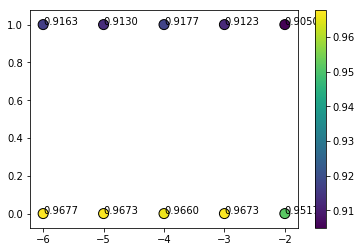

In [9]:
# plt.rcParams['figure.figsize'] = [10, 5]
weight_decay_scatter = ([math.log10(h['weight_decay']) if h['weight_decay'] > 0 else -6 for h in hparams_list])
dropout_scatter = [int(h['dropout_input'] == 0.2) for h in hparams_list]
colors = []
for i in range(len(hparams_list)):
    cur_hparam_tuple = utils.hparamDictToTuple(hparams_list[i])
    colors.append(results[cur_hparam_tuple]['val_acc'][-1])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(weight_decay_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(weight_decay_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (weight_decay_scatter[i], dropout_scatter[i]))
plt.show()

### Train child network using distillation

In [31]:
num_epochs = 60
print_every = 100

In [36]:
temperatures = [2]
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt
alphas = [1.0]
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-5]
momentums = [0.9]
# keeping dropout input = dropout hidden
# dropout_probabilities = [(0.2, 0.5)]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []
for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, 
                                        momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)
    hparams_set.add(utils.hparamDictToTuple(hparam))

results = {}
for hparam in hparams_list:
    print('Training with hparams', end='')
    utils.printHparam(hparam)
    reproducibilitySeed()
    child_net = networks.ChildNetwork()
    child_net = child_net.to(fast_device)
    hparam_tuple = utils.hparamDictToTuple(hparam)
    results[hparam_tuple] = utils.trainChildOnHparam(parent_net, child_net, hparam, num_epochs, 
                                                        train_val_loader, None, 
                                                        print_every=print_every, 
                                                        fast_device=fast_device)
    save_path = 'checkpoints_child/' + utils.hparamToString(hparam) + '_final.tar'
    torch.save({'results' : results[hparam_tuple], 
                'model_state_dict' : child_net.state_dict(), 
                'epoch' : num_epochs}, save_path)


Training with hparams, T=2, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=1e-05
[1,   100/  469] train loss: 1.754 train accuracy: 0.852
[1,   200/  469] train loss: 0.637 train accuracy: 0.945
[1,   300/  469] train loss: 0.814 train accuracy: 0.906
[1,   400/  469] train loss: 0.503 train accuracy: 0.945
[2,   100/  469] train loss: 0.538 train accuracy: 0.938
[2,   200/  469] train loss: 0.357 train accuracy: 0.945
[2,   300/  469] train loss: 0.402 train accuracy: 0.945
[2,   400/  469] train loss: 0.411 train accuracy: 0.930
[3,   100/  469] train loss: 0.432 train accuracy: 0.930
[3,   200/  469] train loss: 0.268 train accuracy: 0.969
[3,   300/  469] train loss: 0.289 train accuracy: 0.945
[3,   400/  469] train loss: 0.243 train accuracy: 0.969
[4,   100/  469] train loss: 0.278 train accuracy: 0.961
[4,   200/  469] train loss: 0.336 train accuracy: 0.938
[4,   300/  469] train loss: 0.220 train accuracy: 0.969
[4,   400/

[36,   100/  469] train loss: 0.077 train accuracy: 0.992
[36,   200/  469] train loss: 0.071 train accuracy: 0.984
[36,   300/  469] train loss: 0.092 train accuracy: 0.984
[36,   400/  469] train loss: 0.090 train accuracy: 0.977
[37,   100/  469] train loss: 0.069 train accuracy: 0.992
[37,   200/  469] train loss: 0.141 train accuracy: 0.977
[37,   300/  469] train loss: 0.079 train accuracy: 0.992
[37,   400/  469] train loss: 0.085 train accuracy: 0.992
[38,   100/  469] train loss: 0.074 train accuracy: 0.977
[38,   200/  469] train loss: 0.088 train accuracy: 0.992
[38,   300/  469] train loss: 0.068 train accuracy: 0.992
[38,   400/  469] train loss: 0.136 train accuracy: 0.953
[39,   100/  469] train loss: 0.100 train accuracy: 0.969
[39,   200/  469] train loss: 0.142 train accuracy: 0.961
[39,   300/  469] train loss: 0.079 train accuracy: 0.992
[39,   400/  469] train loss: 0.066 train accuracy: 0.984
[40,   100/  469] train loss: 0.089 train accuracy: 0.984
[40,   200/  4

In [37]:
# Calculate child test accuracy
test_accuracy = utils.getTestAccuracy(child_net, test_loader, fast_device)
print('child test accuracy (w distillation): ', test_accuracy)

child test accuracy (w distillation):  0.9732


### Hyperparameter search utils

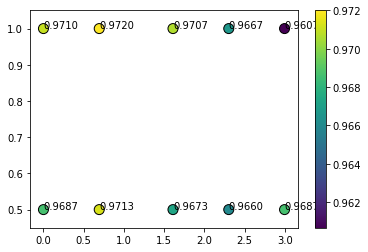

In [27]:
# plt.rcParams['figure.figsize'] = [10, 5]
T_scatter = [math.log(h['T']) for h in hparams_list]
alpha_scatter = [h['alpha'] for h in hparams_list]
colors = []
for i in range(len(hparams_list)):
    cur_hparam_tuple = utils.hparamDictToTuple(hparams_list[i])
    colors.append(results[cur_hparam_tuple]['val_acc'][-1])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(T_scatter, alpha_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(T_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (T_scatter[i], alpha_scatter[i]))
plt.show()

In [30]:
with open('child_hparams_set.dat', 'wb') as f:
    pickle.dump(hparams_set, f)